## Predicting future Blood-Glucose Values for Insulin Delivery (Work-in-Progress)

**### N.B: Do not attempt to use any of this code for automated insulin delivery if you have T1-Diabetes. This is purely for educational purposes and a working progress that is not safe for clinical use at this stage.**

People with T1-Diabetes require insulin injections in order to keep their Blood-Glucose within a healthy range. However, the factors which can affect Blood-Glucose are many, the main ones being: 'Exogenously administered insulin', 'Carbohydrates Consumed(grams)', 'Sensitivity Factors (Carbohydrate + Insulin)', 'Basal Insulin Requirements'. 

These factors are also vary with 24-hour (circadian) cycles of the body, and so are not static/same throughout the day. Other factors (such as exercise) as well as endocrine changes also affect Blood-Glucose.

Additionally, there is a delay when administering insulin before changes take place for glucose to enter cells from the bloodstream, this varies with different types/manufacturers of insulin.  ['NovoRapid'](https://www.ema.europa.eu/en/documents/product-information/novorapid-epar-product-information_en.pdf) is one type of insulin, the time taken for NovoRapid to reach it's maximum effect is unique from other insulin types. This follows an exponential growth and also needs to be modeled in order to understand exactly how much 'active insulin' is working in the body, at any given time-period.

Many thanks to [@mariusae](https://github.com/mariusae/) for sharing his original project for [FiASP](https://www.mynovoinsulin.com/insulin-products/fiasp/home.html) Blood-Glucose prediction, and to [Dragan Maksimovic @dm61](https://github.com/ps2/LoopIOB/blob/master/ScalableExp.ipynb) for his parameterized walsh curve models.

In [9]:
import pandas as pd
from datetime import datetime
import dateutil.parser
import os

import glob
import os.path
import sys
### Marius Imports
import tabulate

import numpy as np
import sys
#sys.path.extend(["/Users/marius/src/tinyap.org/model"])
#from tapmodel import data #this is his data-source
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import dateutil
tz = dateutil.tz.gettz('UTC')
#utc.tzinfo == pytz.ut

In [10]:
#import tensorflow as tf
import tensorflow as tf

#### Pre-liminary step: get data in csv format from multiple dirty .txt unparsed version

In [11]:

path = '/test-data'
sys.argv[1] = path
files = glob.glob(os.path.join(path,"*.txt"))

#list_of_files = os.listdir(path)
#print(list_of_files)
for file in files:#for file in os.listdir(path):
    with open(file,"r") as f:
        
    #if file.endswith(".txt"): 
            #os.path.join(filename2,file)
        first_line = f.readline() #get the first line only
        #df = pd.read_csv(f, skiprows=2, delim_whitespace=True, header=[1])
        aaps_fn_word = str.split(first_line)[2] #get the third index [2] of the first line - string
        aaps_datestring = aaps_fn_word.split("_",)[1::]
        aaps_dateword = aaps_datestring[0]
        #aaps_date_split = aaps_dateword.split("_")[1::] 
        aaps_date_solo = aaps_dateword
        aaps_datestring2= '/'.join(aaps_date_solo.split("-",)[0::])
        aaps_parsed_date = datetime.strptime(aaps_datestring2, "%Y/%m/%d").date()
        df = pd.read_csv(f, skiprows=2, delim_whitespace=True) 
        #^IMPORTANT line: skiprows=3 then switched down to 2 for it to work
        #ALSO: ..whitespace=True, 'Header = [1]' removed 

        df['date']= aaps_parsed_date
        df['time']=pd.to_datetime(df['time'], format='%H:%MZ').dt.time
        #^ used once so it can't do it again
        #d
        df['datetime']=df.apply(lambda r : datetime.combine(r['date'],r['time']),1)

        cols=df.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        df = df[cols]

        input_file = aaps_fn_word
        output_file = input_file.split('.z')[0] +'_df1'
        df.to_csv(output_file, index=False)
        continue
#else:
    #continue
                

#### Concatenate individually parsed .txt files into combined csv

In [ ]:
from pathlib import Path

basepath = Path(r'/Individual Files')
li = []

for csvfile in basepath.glob('*_df1'):
    dfcombined_concat = pd.read_csv(csvfile, index_col=None, header=0)
    li.append(dfcombined_concat)

dfcombined_concat = pd.concat(li, axis=0, ignore_index=True)
dfcombined_concat = dfcombined_concat.sort_values(by='datetime',ascending=True)
#dfcombined_concat.
dfcombined_concat.to_csv(r'/dfcombined.csv')


In [16]:
df_raw = pd.read_csv('IP-Project Data/combined csv/dfcombined_concat.csv', index_col=[0])

## Now that we have parsed the data and loaded it in, let's start

In [17]:
df_raw.head()

,datetime,time,bg,IOB,COB,orig,prof,auto,emul,orig.1,emul.1,orig.2,emul.2,date
0,2021-01-14 09:41:00,09:41:00,100,-0.26,0.0,64.6,50.4,64.6,50.4,0.0,0,0.00,0.0,2021-01-14
1,2021-01-14 09:46:00,09:46:00,101,0.98,13.7,64.6,50.4,64.6,50.4,0.0,0,0.00,0.0,2021-01-14
2,2021-01-14 09:51:00,09:51:00,100,0.91,12.4,64.6,50.4,64.6,50.4,0.0,0,0.00,0.0,2021-01-14
3,2021-01-14 09:56:00,09:56:00,99,0.84,11.0,64.6,50.4,64.6,50.4,0.0,0,0.00,0.0,2021-01-14
4,2021-01-14 10:01:00,10:01:00,105,0.77,9.7,64.6,50.4,64.6,50.4,0.0,0,0.86,0.0,2021-01-14


In [18]:
df_renamed = df_raw.rename(columns={'bg': 'sgv',})
df_renamed.head()


,datetime,time,sgv,IOB,COB,orig,prof,auto,emul,orig.1,emul.1,orig.2,emul.2,date
0,2021-01-14 09:41:00,09:41:00,100,-0.26,0.0,64.6,50.4,64.6,50.4,0.0,0,0.00,0.0,2021-01-14
1,2021-01-14 09:46:00,09:46:00,101,0.98,13.7,64.6,50.4,64.6,50.4,0.0,0,0.00,0.0,2021-01-14
2,2021-01-14 09:51:00,09:51:00,100,0.91,12.4,64.6,50.4,64.6,50.4,0.0,0,0.00,0.0,2021-01-14
3,2021-01-14 09:56:00,09:56:00,99,0.84,11.0,64.6,50.4,64.6,50.4,0.0,0,0.00,0.0,2021-01-14
4,2021-01-14 10:01:00,10:01:00,105,0.77,9.7,64.6,50.4,64.6,50.4,0.0,0,0.86,0.0,2021-01-14


In [19]:
df = df_renamed[['sgv','IOB','COB']].copy() #[[]] double sq brackets to select multiple columns


df['IOB'] = df['IOB'].apply(lambda x: x*1000) # sat 10th: this seems to be too much
df['sgv'] = df['sgv'].astype(float)

In [20]:
df.head()

,sgv,IOB,COB
0,100.0,-260.0,0.0
1,101.0,980.0,13.7
2,100.0,910.0,12.4
3,99.0,840.0,11.0
4,105.0,770.0,9.7


In [21]:
frame = df

In [22]:
# Maxdelta is the maximum allowable glucose delta.
# We clip deltas greater than maxdelta or smaller than -maxdelta.
maxdelta = 15

frame['deltasgv'] = frame['sgv'] - frame['sgv'].shift(1)
frame['deltasgv'] = np.maximum(np.minimum(frame['deltasgv'], maxdelta), -maxdelta)

frame['meandeltasgv'] = frame['deltasgv'].rolling(window=4, min_periods=1).mean()
frame['prevmeandeltasgv'] = frame['meandeltasgv'].shift(1)
frame[np.isfinite(frame['sgv'])].tail(5)

,sgv,IOB,COB,deltasgv,meandeltasgv,prevmeandeltasgv
3379,138.0,30.0,0.0,-2.0,1.50,2.25
3380,141.0,-10.0,0.0,3.0,2.00,1.50
3381,144.0,-10.0,0.0,3.0,1.50,2.00
3382,144.0,10.0,0.0,0.0,1.00,1.50
3383,147.0,10.0,0.0,3.0,2.25,1.00


In [23]:
from math import isnan 

To get carbohydrate activity, first need to work out how much carbohydrate has been absorbed cA, then work out carbohydrate activity based on 'average carbohydrate parameter'

So if i eat 12g of carbohydrate:..
    Carbohydrates on Board = 12g
    ...+5 mins COB = 10.5g (-1.5g absorbed)
            ...+5 mins I eat 5g carbs COB= 10.5+ 5g =15.5g, 
            
Okay so pretty simple, carbs absorbed/activity is any -ive decrease in COB, any positive(+) increase of COB is external carbs being consumed.
 - calculate the deltas (positive and negative)

In [24]:


def expia(t, tp, td):
    """Exponential insulin curve, parameterized by peak and duration, 
    due to Dragan Maksimovic (@dm61).
    Worked by Pete (@ps2) in the notebook
    	https://github.com/ps2/LoopIOB/blob/master/ScalableExp.ipynb
    Reworked here to be vectorized by numpy.
    """
    tau = tp*(1-tp/td)/(1-2*tp/td)
    a = 2*(tau/td)
    S = 1/(1-a+(1+a)*np.exp(-td/tau))
    return np.maximum(0., (S/np.power(tau,2))*t*(1-t/td)*np.exp(-t/tau))


# W is the window of history that we consider. 
# Our periods are 5 minutes, so 12*6 = 6 hours.
W = 12*6
Wtime = np.linspace(0., 1.*W, W, endpoint=False, dtype='float64')
novorapid_coeffs = expia(Wtime, 13., 60.)  # 1:05h (75mins) peak, 5h duration

#humalog_coeffs = expia(Wtime, 13., 48.)  # 1:05h peak, 4h duration
#fiasp_coeffs = expia(Wtime, 7., 45.)  # 35m peak, 3:45h duration

# We flip them because we're going to be applying these to "trailing" data.
novorapid_coeffs = np.flip(novorapid_coeffs, 0)
#humalog_coeffs = np.flip(humalog_coeffs, 0)
#fiasp_coeffs = np.flip(fiasp_coeffs, 0)

# change IOB/deltaipid into the same units as marius (mU(10**-3) instead of units)

# Ia indicates insulin activity. This is computed by adding up the 
# contributions of each delivery over a rolling window. Conveniently,
# this is equivalent to taking the dot product of the deliveries in the
# window with the coefficients computed above.

#ZT:my version of above
frame['ia']=frame['IOB'].rolling(window=W).apply(lambda pids: np.dot(pids, novorapid_coeffs))
#.#apply(novorapid_coeffs)#(lambda novo: np.vectorize(novorapid_coeffs))#.apply(lambda IOB: np.int(novorapid_coeffs))
#print(novorapid_coeffs)
frame[np.isfinite(frame['sgv'])].tail(5)

,sgv,IOB,COB,deltasgv,meandeltasgv,prevmeandeltasgv,ia
3379,138.0,30.0,0.0,-2.0,1.50,2.25,-0.295942
3380,141.0,-10.0,0.0,3.0,2.00,1.50,5.722513
3381,144.0,-10.0,0.0,3.0,1.50,2.00,11.313416
3382,144.0,10.0,0.0,0.0,1.00,1.50,16.518049
3383,147.0,10.0,0.0,3.0,2.25,1.00,21.535198


In [25]:
frame.head()

,sgv,IOB,COB,deltasgv,meandeltasgv,prevmeandeltasgv,ia
0,100.0,-260.0,0.0,NaN,NaN,NaN,NaN
1,101.0,980.0,13.7,1.0,1.000000,NaN,NaN
2,100.0,910.0,12.4,-1.0,0.000000,1.000000,NaN
3,99.0,840.0,11.0,-1.0,-0.333333,0.000000,NaN
4,105.0,770.0,9.7,6.0,1.250000,-0.333333,NaN


In [26]:
## removing NaN for 'ia' column

for i in range(len(frame)) :
    if isnan(frame.iloc[i, 6]) == True:
             frame.iloc[i,6] = 0
    continue
             

In [27]:
frame.head()

,sgv,IOB,COB,deltasgv,meandeltasgv,prevmeandeltasgv,ia
0,100.0,-260.0,0.0,NaN,NaN,NaN,0.0
1,101.0,980.0,13.7,1.0,1.000000,NaN,0.0
2,100.0,910.0,12.4,-1.0,0.000000,1.000000,0.0
3,99.0,840.0,11.0,-1.0,-0.333333,0.000000,0.0
4,105.0,770.0,9.7,6.0,1.250000,-0.333333,0.0


In [28]:
# removing NaN for prevmeandeltasgv column
for i in range(len(frame)) :
    if isnan(frame.iloc[i, 5]) == True:
             frame.iloc[i,5] = 0
    continue
             

### Carb absorption walsh curves

In [25]:
def walshca(t, tdel, tdur):
    """Walsh carb absorption curves with provided delays and duration."""
    return ((t >= tdel) & (t <= tdel+tdur/2)) * (4*(t-tdel)/np.square(tdur)) + \
        ((t > tdel+tdur/2) & (t <= tdel+tdur)) * (4/tdur * (1-(t-tdel)/tdur))

# Carbohydrate parameters (delay, duration): XS, S, M, L.
carb_params = {'COB': (3., 24.)}


carb_coeffs = {which: walshca(Wtime, tdel, tdur) for (which, (tdel, tdur)) in carb_params.items()}
carb_coeffs = {which: np.flip(coeffs, 0) for (which, coeffs) in carb_coeffs.items()}

frame['ca'] = np.zeros(len(frame))
# Add up the contributions from each carbohydrate type.
for column, coeffs in carb_coeffs.items():
    frame['ca'] += frame[column].rolling(window=W).apply(lambda ucis: np.dot(ucis, coeffs))

frame[np.isfinite(frame['sgv'])].tail(5)

,sgv,IOB,COB,deltasgv,meandeltasgv,prevmeandeltasgv,ia,ca
time,,,,,,,,
05/02/2021 20:42,252.0,3710.0,13.4,-3.0,0.00,1.25,3221.794438,19.161111
05/02/2021 20:47,245.0,3530.0,12.1,-7.0,-3.25,0.00,3270.646778,18.694444
05/02/2021 20:52,235.0,3370.0,13.8,-10.0,-5.50,-3.25,3315.032751,18.209722
05/02/2021 20:57,229.0,3110.0,12.4,-6.0,-6.50,-5.50,3354.349228,17.793056
05/02/2021 21:02,229.0,2900.0,11.1,0.0,-5.75,-6.50,3387.476186,17.458333


In [27]:
frame.head()

,sgv,IOB,COB,deltasgv,meandeltasgv,prevmeandeltasgv,ia,ca
time,,,,,,,,
01/01/2021 04:01,112.0,-340.0,0.0,15.0,15.0,0.0,0.0,NaN
01/01/2021 04:06,111.0,-330.0,0.0,-1.0,7.0,15.0,0.0,NaN
01/01/2021 04:11,112.0,-330.0,0.0,1.0,5.0,7.0,0.0,NaN
01/01/2021 04:16,109.0,-350.0,0.0,-3.0,3.0,5.0,0.0,NaN
01/01/2021 04:21,110.0,-390.0,0.0,1.0,-0.5,3.0,0.0,NaN


In [28]:
# removing NaN from 'ca' column
for i in range(len(frame)) :
    if isnan(frame.iloc[i, 7]) == True:
             frame.iloc[i,7] = 0
    continue

In [29]:
frame.head()

,sgv,IOB,COB,deltasgv,meandeltasgv,prevmeandeltasgv,ia,ca
time,,,,,,,,
01/01/2021 04:01,112.0,-340.0,0.0,15.0,15.0,0.0,0.0,0.0
01/01/2021 04:06,111.0,-330.0,0.0,-1.0,7.0,15.0,0.0,0.0
01/01/2021 04:11,112.0,-330.0,0.0,1.0,5.0,7.0,0.0,0.0
01/01/2021 04:16,109.0,-350.0,0.0,-3.0,3.0,5.0,0.0,0.0
01/01/2021 04:21,110.0,-390.0,0.0,1.0,-0.5,3.0,0.0,0.0


In [38]:
type(frame)

pandas.core.frame.DataFrame

In [40]:
frame.loc[:,['ia']].dtypes

ia    float64
dtype: object

In [42]:
print('is nan', frame[np.isfinite(frame['ca'])].isna().values.any()) 
print('is null', frame[np.isfinite(frame['ca'])].isnull().values.any()) 


is nan False
is null False


### Okay now using tensorflow to define and fit a model to these data

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [50]:
# Quelch annoying Tensorflow warnings.
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

class model:
    # The following are the columns we're using in our model.
    # The use of 'None' here indicates that the value of the dimension
    # is unknown until runtime. In our case, it's the number of samples
    # that we run through each iteration.
    car = tf.placeholder(tf.float32, [None, 1], name='car')
    ia = tf.placeholder(tf.float32, [None, 1], name='ia')
    prevdelta = tf.placeholder(tf.float32, [None, 1], name='prevdelta')
    #prevdelta = tf.Variable(tf.ones(shape=[None, self._num_states], name='prevdelta'), dtype=tf.float32)
    
    # And the following are the (learned) parameters:
    egp_effect = tf.Variable(0., name='egp_effect')
    carb_coeff = tf.Variable(0., name='carb_coeff')
    insulin_coeff = tf.Variable(0., name='insulin_coeff')
    prevdelta_coeff = tf.Variable(0., name='delta_coeff')

    # Our model, as defined above:
    predicted_delta = egp_effect + carb_coeff*car - insulin_coeff*ia + prevdelta_coeff*prevdelta


Now we've got the learned variables/coefficients, let's find the best fit when applied to our data

In terms of optimizers, we'll use gradient descent on our loss function, specifically we'll start by using the mean squared error loss function

In [51]:
actual_delta = tf.placeholder(tf.float32, [None, 1], name='delta')
# m is the batch size. We have to determine this dynamically
# since our input sizes may vary.
m = tf.cast(tf.shape(actual_delta)[0], tf.float32)
loss = tf.reduce_sum(tf.square(actual_delta - model.predicted_delta)) / (2*m)

Now let's train the model we defined above using a gradient descent optimizer. Let's start by splitting our dataset into two test/training 

In [52]:
# Select all the rows that are defined for the columns we use in our model.
# Note that this can make our data frame noncontiguous, but that's ok since
# we've already computed the values (ca and ia) that depend on contiguous data.
rows = np.isfinite(frame['meandeltasgv']) \
    & np.isfinite(frame['prevmeandeltasgv']) \
    & np.isfinite(frame['ca']) \
    & np.isfinite(frame['ia'])

filtered = frame[rows]
filtered.tail(5)

,sgv,IOB,COB,deltasgv,meandeltasgv,prevmeandeltasgv,ia,ca
time,,,,,,,,
05/02/2021 20:42,252.0,3710.0,13.4,-3.0,0.00,1.25,3221.794438,19.161111
05/02/2021 20:47,245.0,3530.0,12.1,-7.0,-3.25,0.00,3270.646778,18.694444
05/02/2021 20:52,235.0,3370.0,13.8,-10.0,-5.50,-3.25,3315.032751,18.209722
05/02/2021 20:57,229.0,3110.0,12.4,-6.0,-6.50,-5.50,3354.349228,17.793056
05/02/2021 21:02,229.0,2900.0,11.1,0.0,-5.75,-6.50,3387.476186,17.458333


In [54]:
filtered.head(5)
#okay so I need to change the index to be the time column, he did it during the read_csv

,sgv,IOB,COB,deltasgv,meandeltasgv,prevmeandeltasgv,ia,ca
time,,,,,,,,
01/01/2021 04:01,112.0,-340.0,0.0,15.0,15.0,0.0,0.0,0.0
01/01/2021 04:06,111.0,-330.0,0.0,-1.0,7.0,15.0,0.0,0.0
01/01/2021 04:11,112.0,-330.0,0.0,1.0,5.0,7.0,0.0,0.0
01/01/2021 04:16,109.0,-350.0,0.0,-3.0,3.0,5.0,0.0,0.0
01/01/2021 04:21,110.0,-390.0,0.0,1.0,-0.5,3.0,0.0,0.0


In [70]:

filtered = filtered[['sgv','deltasgv','meandeltasgv','prevmeandeltasgv','ia','ca']].copy() #[[]] double sq brackets to select multiple columns


Now let's shuffle the data and split it into 95% training data (for parameter estimation) and 5% test data (to test our model)

In [71]:
shuffled = filtered.sample(frac=1)
n = int(len(shuffled)*0.95)
train, test = shuffled[:n], shuffled[n:]

In [72]:
#filtered.head(10)
print(len(train))

3214


In [ ]:
def train_feed_dict(batch):
    """Construct a data dictionary from a batch (a pandas frame)."""
    return {
        model.car: batch['ca'].values.reshape([-1, 1]),
        model.ia: batch['ia'].values.reshape([-1, 1]),
        model.prevdelta: batch['prevmeandeltasgv'].values.reshape([-1, 1]),
        actual_delta: batch['meandeltasgv'].values.reshape([-1, 1]),
    }

# The number of epochs to run through. Each epoch sees the entirety
# of the (training) data set.
nepoch = 1000
learning_step = tf.train.AdagradOptimizer(1.0).minimize(loss)

# batch_size is the number of samples we run through each mini-batch
# when training.
batch_size = 3200

nbatch = int(len(train)/batch_size)
if nbatch < 1:
    raise ValueError('not enough data')

feed_dicts = []
for i in range(nbatch):
    batch = train[i*batch_size:(i+1)*batch_size]
    feed_dicts.append(train_feed_dict(batch))

test_feed_dict = train_feed_dict(test)

# Tensorflow needs a session within which to run our 
# computation graphs.
sess = tf.InteractiveSession()

sess.run(tf.global_variables_initializer())
for e in range(nepoch):
    for i in range(nbatch):
        sess.run(learning_step, feed_dict=feed_dicts[i])
    # Print the loss periodically so we can monitor progress.
    if e%500 == 0:
        est_loss = sess.run(loss, test_feed_dict)
        print('epoch {} loss {}'.format(e, est_loss))

est_loss = sess.run(loss, test_feed_dict)
print('final loss: {}'.format(est_loss))
est_egp_effect, est_carb_coeff, est_insulin_coeff, est_prevdelta_coeff = \
    sess.run([model.egp_effect, model.carb_coeff, model.insulin_coeff, model.prevdelta_coeff])
tab = [
    ["EGP",       est_egp_effect],
    ["Carb",      est_carb_coeff],
    ["Insulin",   est_insulin_coeff],             
    ["Prevdelta", est_prevdelta_coeff],
]
display(tabulate.tabulate(tab, tablefmt='html'))

In [ ]:
def train_feed_dict(batch):
    """Construct a data dictionary from a batch (a pandas frame)."""
    return {
        model.car: batch['ca'].values.reshape([-1, 1]),
        model.ia: batch['ia'].values.reshape([-1, 1]),
        model.prevdelta: batch['prevmeandeltasgv'].values.reshape([-1, 1]),
        actual_delta: batch['meandeltasgv'].values.reshape([-1, 1]),
    }

# The number of epochs to run through. Each epoch sees the entirety
# of the (training) data set.
nepoch = 1000
learning_step = tf.train.AdagradOptimizer(1.0).minimize(loss)

# batch_size is the number of samples we run through each mini-batch
# when training.
batch_size = 3200

nbatch = int(len(train)/batch_size)
if nbatch < 1:
    raise ValueError('not enough data')

feed_dicts = []
for i in range(nbatch):
    batch = train[i*batch_size:(i+1)*batch_size]
    feed_dicts.append(train_feed_dict(batch))

test_feed_dict = train_feed_dict(test)

# Tensorflow needs a session within which to run our 
# computation graphs.
sess = tf.InteractiveSession()

sess.run(tf.global_variables_initializer())
for e in range(nepoch):
    for i in range(nbatch):
        sess.run(learning_step, feed_dict=feed_dicts[i])
    # Print the loss periodically so we can monitor progress.
    if e%500 == 0:
        est_loss = sess.run(loss, test_feed_dict)
        print('epoch {} loss {}'.format(e, est_loss))

est_loss = sess.run(loss, test_feed_dict)
print('final loss: {}'.format(est_loss))
est_egp_effect, est_carb_coeff, est_insulin_coeff, est_prevdelta_coeff = \
    sess.run([model.egp_effect, model.carb_coeff, model.insulin_coeff, model.prevdelta_coeff])
tab = [
    ["EGP",       est_egp_effect],
    ["Carb",      est_carb_coeff],
    ["Insulin",   est_insulin_coeff],             
    ["Prevdelta", est_prevdelta_coeff],
]
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')


In [ ]:
def train_feed_dict(batch):
    """Construct a data dictionary from a batch (a pandas frame)."""
    return {
        model.car: batch['ca'].values.reshape([-1, 1]),
        model.ia: batch['ia'].values.reshape([-1, 1]),
        model.prevdelta: batch['prevmeandeltasgv'].values.reshape([-1, 1]),
        actual_delta: batch['meandeltasgv'].values.reshape([-1, 1]),
    }

# The number of epochs to run through. Each epoch sees the entirety
# of the (training) data set.
nepoch = 1000
learning_step = tf.train.AdagradOptimizer(1.0).minimize(loss)

# batch_size is the number of samples we run through each mini-batch
# when training.
batch_size = 3200

nbatch = int(len(train)/batch_size)
if nbatch < 1:
    raise ValueError('not enough data')

feed_dicts = []
for i in range(nbatch):
    batch = train[i*batch_size:(i+1)*batch_size]
    feed_dicts.append(train_feed_dict(batch))

test_feed_dict = train_feed_dict(test)

# Tensorflow needs a session within which to run our 
# computation graphs.
sess = tf.InteractiveSession()

sess.run(tf.global_variables_initializer())
for e in range(nepoch):
    for i in range(nbatch):
        sess.run(learning_step, feed_dict=feed_dicts[i])
    # Print the loss periodically so we can monitor progress.
    if e%500 == 0:
        est_loss = sess.run(loss, test_feed_dict)
        print('epoch {} loss {}'.format(e, est_loss))

est_loss = sess.run(loss, test_feed_dict)
print('final loss: {}'.format(est_loss))
est_egp_effect, est_carb_coeff, est_insulin_coeff, est_prevdelta_coeff = \
    sess.run([model.egp_effect, model.carb_coeff, model.insulin_coeff, model.prevdelta_coeff])
tab = [
    ["EGP",       est_egp_effect],
    ["Carb",      est_carb_coeff],
    ["Insulin",   est_insulin_coeff],             
    ["Prevdelta", est_prevdelta_coeff],
]
display(tabulate.tabulate(tab, tablefmt='html'))

What do these estimated coefficients mean?

- EGP: Endogenous Glucose Production, i.e. the basal rate of insulin required to keep blood-glucose constant 
- Carb & Insulin: How much Carbs needed for Insulin dosage or vice versa 
- Prevdelta: Amount by which blood glucose will tend to move in the same direction since last reading. Accounts for Blood-glucose changes which unrelated to carb/insulin factors.


In [ ]:
display(tabulate.tabulate(tab, tablefmt='html'))


### Predicting future blood glucose values


In [74]:
def plot_glucose(time, actual, predicted):
    """Plot actual vs. predicted glucose."""
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_ylabel('blood glucose (mg/dL)')
    ax.set_xlabel('time')
    ax.plot(time, actual, label='actual')
    ax.plot(time, predicted, label='predicted')
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))
    fmt = DateFormatter('%H:%M', tz=tz)
    ax.xaxis.set_major_formatter(fmt)
    plt.legend()
    plt.show()

### Predicting Blood Glucose -  a single time step of 3 hours

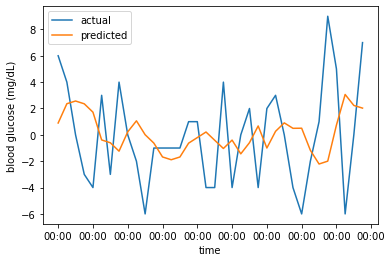

In [119]:
testframe = frame[(frame.index >= '04/02/2021 00:00') & (frame.index <= '04/02/2021 03:00')]
predicted_deltas = sess.run(model.predicted_delta, feed_dict=train_feed_dict(testframe))
plot_glucose(testframe.index, testframe.deltasgv, predicted_deltas)

### Next: Synthesize typical scenarios and predicted Blood Glucose